In [4]:
from google.colab import drive
drive.mount('/content/gdrive')
import cv2
import os
import random

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [5]:
# %cd /content/gdrive/MyDrive
# !unzip /content/gdrive/MyDrive/AGCCPF.zip

In [6]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import pandas as pd
%matplotlib inline

In [7]:
import tensorflow as tf
import tensorflow.keras as keras


In [8]:
tf.__version__

'2.8.0'

In [9]:
tf.random.set_seed(42)
np.random.seed(42)


In [10]:
train_dir = "/content/gdrive/MyDrive/AGCCPF/train"
test_dir = "/content/gdrive/MyDrive/AGCCPF/test"
valid_dir = "/content/gdrive/MyDrive/AGCCPF/validate"


In [11]:
from keras.preprocessing.image import ImageDataGenerator

In [12]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=False)
test_datagen = ImageDataGenerator(rescale=1./255)

In [13]:

train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=(224, 224),
        batch_size=20,
        class_mode='categorical',
        shuffle=True
        )

valid_generator = test_datagen.flow_from_directory(
        valid_dir,
        target_size=(224, 224),
        batch_size=20,
        class_mode='categorical',
        shuffle=True
        )

test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=(224, 224),
        batch_size=20,
        class_mode='categorical',
        shuffle=False
        )

Found 5253 images belonging to 3 classes.
Found 1315 images belonging to 3 classes.
Found 1644 images belonging to 3 classes.


In [14]:
from tensorflow.keras import layers
from tensorflow.keras import models

In [15]:
from tensorflow.keras import optimizers

In [16]:
from tensorflow.keras.applications import MobileNet
# conv_base = VGG16(weights='imagenet',
#                   include_top=False,
#                   input_shape=(224, 224, 3))


# conv_base = EfficientNetB7(weights='imagenet',
#                   include_top=False,
#                   input_shape=(150, 150, 3))

# conv_base = DenseNet121(weights='imagenet',
#                   include_top=False,
#                   input_shape=(224, 224, 3))

conv_base = MobileNet(weights='imagenet',
                  include_top=False,
                  input_shape=(224, 224, 3))

In [17]:
conv_base.summary()

Model: "mobilenet_1.00_224"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 112, 112, 32)      864       
                                                                 
 conv1_bn (BatchNormalizatio  (None, 112, 112, 32)     128       
 n)                                                              
                                                                 
 conv1_relu (ReLU)           (None, 112, 112, 32)      0         
                                                                 
 conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)     288       
                                                                 
 conv_dw_1_bn (BatchNormaliz  (None, 112, 112, 32)     128       
 ation)                                         

In [18]:
model = keras.models.Sequential()
model.add(conv_base)
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(256, activation='relu'))
model.add(keras.layers.Dense(3, activation='softmax'))



In [19]:
# model = models.Sequential()
# model.add(layers.Conv2D(32, (3, 3), activation='relu',
#                         input_shape=(150, 150, 3)))
# model.add(layers.MaxPooling2D((2, 2)))
# model.add(layers.Conv2D(64, (3, 3), activation='relu'))
# model.add(layers.MaxPooling2D((2, 2)))
# model.add(layers.Conv2D(128, (3, 3), activation='relu'))
# model.add(layers.MaxPooling2D((2, 2)))
# model.add(layers.Conv2D(128, (3, 3), activation='relu'))
# model.add(layers.MaxPooling2D((2, 2)))
# model.add(layers.Flatten())
# model.add(layers.Dropout(0.5))
# model.add(layers.Dense(512, activation='relu'))
# model.add(layers.Dense(3, activation='softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-5),
              metrics=['acc',tf.keras.metrics.Recall(),tf.keras.metrics.Precision()])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/rmsprop.py:130: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


In [20]:
%cd /content/gdrive/MyDrive/

/content/gdrive/MyDrive


In [21]:
checkpoint_cb = keras.callbacks.ModelCheckpoint(
    "/content/gdrive/MyDrive/model.h5", save_best_only=True)
earlystop_cb = keras.callbacks.EarlyStopping(
    patience=5, restore_best_weights=True)


In [22]:
model.summary(0)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenet_1.00_224 (Functio  (None, 7, 7, 1024)       3228864   
 nal)                                                            
                                                                 
 flatten (Flatten)           (None, 50176)             0         
                                                                 
 dense (Dense)               (None, 256)               12845312  
                                                                 
 dense_1 (Dense)             (None, 3)                 771       
                                                                 
Total params: 16,074,947
Trainable params: 16,053,059
Non-trainable params: 21,888
_________________________________________________________________


In [23]:
history = model.fit(train_generator,
                    steps_per_epoch=260,
                    epochs=50,
                    validation_data=valid_generator,
                    validation_steps=60,
                    callbacks=[checkpoint_cb])


Epoch 1/50
260/260 [==============================] - 151s 515ms/step - loss: 1.3261 - acc: 0.4660 - recall: 0.4200 - precision: 0.4764 - val_loss: 1.0969 - val_acc: 0.5217 - val_recall: 0.4633 - val_precision: 0.5451
Epoch 2/50
260/260 [==============================] - 126s 483ms/step - loss: 1.0174 - acc: 0.5213 - recall: 0.4365 - precision: 0.5390 - val_loss: 1.0045 - val_acc: 0.5308 - val_recall: 0.4258 - val_precision: 0.5448
Epoch 3/50
260/260 [==============================] - 129s 495ms/step - loss: 0.9511 - acc: 0.5507 - recall: 0.4668 - precision: 0.5762 - val_loss: 1.0312 - val_acc: 0.5350 - val_recall: 0.4833 - val_precision: 0.5540
Epoch 4/50
260/260 [==============================] - 128s 492ms/step - loss: 0.9391 - acc: 0.5602 - recall: 0.4822 - precision: 0.5867 - val_loss: 1.0062 - val_acc: 0.5175 - val_recall: 0.4450 - val_precision: 0.5432
Epoch 5/50
260/260 [==============================] - 129s 496ms/step - loss: 0.9120 - acc: 0.5785 - recall: 0.5055 - precision:

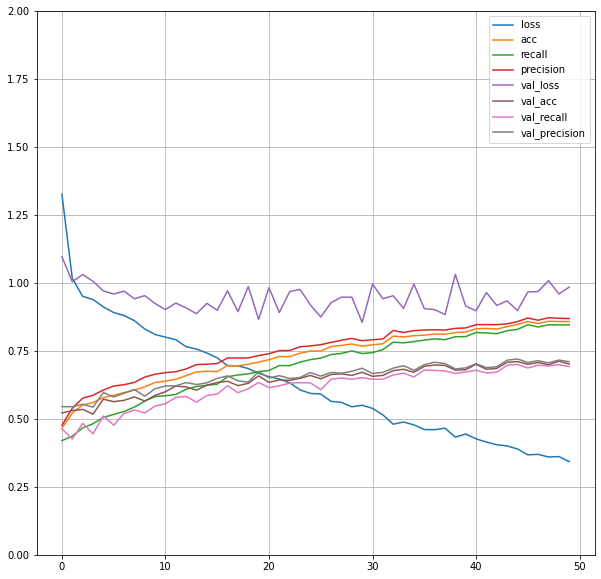

In [24]:
pd.DataFrame(history.history).plot(figsize=(10, 10))
plt.ylim((0,2))
plt.grid(True)
plt.show()

In [25]:
model.evaluate(test_generator)

83/83 [==============================] - 15s 174ms/step - loss: 1.0011 - acc: 0.7226 - recall: 0.7117 - precision: 0.7272


[1.0010653734207153,
 0.7226277589797974,
 0.7116788029670715,
 0.7271597385406494]

In [26]:
x=model.predict(test_generator)
actual=test_generator.labels
pred=np.argmax(x, axis=1)
from sklearn.metrics import confusion_matrix
confusion_matrix(actual,pred)

array([[171,  92,  25],
       [ 31, 735, 104],
       [ 10, 194, 282]])